In [1]:
%pip install Flask==2.0.3
%pip install requests==2.27.1
%pip install scikit-learn==1.0.2
%pip install numpy==1.21.5
%pip install tqdm==4.63.0
%pip install torch==1.9.0
%pip install rich==12.0.0
%pip install seqeval==1.2.2
%pip install matplotlib.pyplot==3.5.2
%pip install seaborn==0.12.2
%pip install transformers==4.28.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot==3.5.2 (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot==3.5.2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle==0.7.5 (from versions: none)
ERROR: No matching distribution found for pickle==0.7.5
Note: yo

Importing librairies

In [251]:
import torch
import numpy as np
import json
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import os
from seqeval.scheme import IOB2
from seqeval.metrics import accuracy_score, f1_score
from transformers import AutoModel, AutoTokenizer, Trainer, TrainingArguments
import tarfile
from ray import tune

Loading data

In [3]:
class TextDataset(torch.utils.data.Dataset):
  def __init__(self, file):
    self.id, self.lemmas, self.pos_tags, self.words = [], [], [], []
    self.instance_ids, self.senses, self.candidates = [], [], []
    self.data = {}
    with open(file) as f:
        self.data = json.loads(f.read())
    counter = 0
    for self.key in self.data:
      self.id.append(counter)
      self.lemmas.append(self.data[self.key]["lemmas"])
      self.pos_tags.append(self.data[self.key]["pos_tags"])
      self.words.append(self.data[self.key]["words"])
      self.instance_ids.append(self.data[self.key]["instance_ids"])
      self.senses.append(self.data[self.key]["senses"])
      self.candidates.append(self.data[self.key]["candidates"])
      counter += 1

  
  def __getitem__(self, idx):
        return {'id' : self.key,
                'lemmas' : self.lemmas[idx], 
                'pos_tags' : self.pos_tags[idx],
                'words' : self.words[idx],
                'instance_ids' : self.instance_ids[idx],
                'senses' : self.senses[idx],
                'candidates' : self.candidates[idx]
                }

  def __len__(self):
        return len(self.data)

In [4]:
datapath = os.path.abspath('Coarse-Grained-WSD/data.tar.gz')

In [5]:
tar = tarfile.open(datapath)
path_folder = datapath.replace('Coarse-Grained-WSD/data/data.tar.gz', "data_unzipped")
tar.extractall(path_folder)

In [6]:
train_dataset = TextDataset(path_folder + "/coarse-grained/train_coarse_grained.json")
print(len(train_dataset))

12339


In [7]:
test_dataset = TextDataset(path_folder + "/coarse-grained/test_coarse_grained.json")
print(len(test_dataset))

686


In [8]:
val_dataset = TextDataset(path_folder + "/coarse-grained/val_coarse_grained.json")
print(len(val_dataset))

685


In [9]:
map_file = path_folder + "/map/coarse_fine_defs_map.json"
with open(map_file) as f:
    mapping = json.loads(f.read())

My model

In [43]:
class MyModel(torch.nn.Module):
    def __init__(self):
      super().__init__()
      self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
      self.transformer_model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)
      
      # Binary classification (no or yes)
      self.classifier = torch.nn.Linear(
              self.transformer_model.config.hidden_size, 2, bias=False
          )
      
    def forward(self, sentence, definition, id):
        
      # Taking the definition of the cluter's first element
      inp = self.tokenizer(sentence, definition[0], padding=True, truncation=True, return_tensors="pt")
      output = self.transformer_model(**inp)
      last_hidden_state_target_word = output[0][0][int(id)]
      logits = self.classifier(last_hidden_state_target_word)
    
      return logits

Training

In [236]:
class MyTrainer():
  def __init__(self, model):
    self.model = model
    self.loss_fct = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)

  def train(self, train_dataset, epochs):
    batch_counter = 0
    batch_size = 32
    train_losses = []
    for epoch in range(epochs): 
      print("")
      print("epoch", epoch)
      self.model.train()
      epoch_loss = 0
      for i in range(batch_counter, batch_size+batch_counter):
        self.optimizer.zero_grad()
        inp = train_dataset[i]
        idx_word_of_interest = inp['candidates'].keys()
        sentence = ' '.join(inp['lemmas'])
        for id in idx_word_of_interest: # For each target word
            clusters = inp['candidates'][id]
            number_of_tags = len(clusters)
            true_cluster = inp['senses'][id][0]
            if number_of_tags == 1: # Word has one candidate cluster
                pass # Do nothing (no prediction)
            else: # Word has more than one candidate cluster
                binary_labels = []
                all_logits = []
                for cluster in clusters :
                    def_cluster = [list(mapping[cluster][i].values())[0] for i in range(len(mapping[cluster]))]
                    logits = self.model(sentence, def_cluster, int(id))
                    all_logits.append(logits)
                    if cluster != true_cluster:
                        binary_labels.append(0) # 0 corresponds to 'no'
                    else:
                        binary_labels.append(1) # 1 corresponds to 'yes'
                binary_labels_t = torch.LongTensor(binary_labels)
                all_logits_t = torch.stack(all_logits)
                loss = self.loss_fct(all_logits_t, binary_labels_t)
                epoch_loss += loss
                loss.backward()
                self.optimizer.step()

      print(epoch_loss/batch_size)
      train_losses.append(epoch_loss/batch_size)
      batch_counter += 32
      
    return train_losses

  def evaluate(self, test_dataset, epochs):
      test_losses = []
      self.model.eval()
      truth = []
      prediction = []
      truths = []
      predictions = []
      with torch.inference_mode():
          for i in range(epochs):
            truth = []
            prediction = []
            inp = test_dataset[i]
            idx_word_of_interest = inp['candidates'].keys()
            sentence = ' '.join(inp['lemmas'])
            for id in idx_word_of_interest:
                clusters = inp['candidates'][id]
                number_of_tags = len(clusters)
                true_cluster = inp['senses'][id][0]
                truth.append(true_cluster)
                if number_of_tags == 1:
                    loss = torch.tensor(0, dtype=torch.float64) # No loss because only one choice
                    test_losses.append(loss) 
                    prediction.append(true_cluster)
                else:
                    binary_labels = []
                    all_logits = []
                    all_logits_yes = []
                    for cluster in clusters :
                        def_cluster = [list(mapping[cluster][i].values())[0] for i in range(len(mapping[cluster]))]
                        logits = self.model(sentence, def_cluster, int(id))
                        all_logits_yes.append(logits[1])
                        all_logits.append(logits)  
                        if cluster != true_cluster:
                            binary_labels.append(0) # 0 corresponds to 'no'
                        else:
                            binary_labels.append(1) # 1 corresponds to 'yes'
                    binary_labels_t = torch.LongTensor(binary_labels)
                    all_logits_t = torch.stack(all_logits)
                    all_logits_yes_t = torch.stack(all_logits_yes)
                    idx_pred_label = torch.argmax(all_logits_yes_t)
                    prediction.append(inp['candidates'][id][idx_pred_label])
                    loss = self.loss_fct(all_logits_t, binary_labels_t)                 
                    test_losses.append(loss)
            truths.append(truth)
            predictions.append(prediction) 
      
      return test_losses, truths, predictions

In [237]:
mymodel = MyModel()
trainer = MyTrainer(model=mymodel)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_losses = trainer.train(train_dataset, 4)

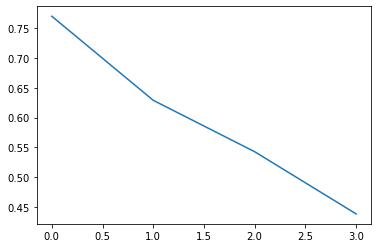

In [222]:
epoch_count = range(0, 4)
tr_losses = [x.detach().numpy() for x in train_losses]
plt.plot(epoch_count, tr_losses)

Testing

In [240]:
test_losses, t, p = trainer.evaluate(test_dataset, 686)

In [241]:
av_test_losses = sum(test_losses)/len(test_losses)
print(av_test_losses)

tensor(0.3248, dtype=torch.float64)


In [156]:
# Counting how many words that have one unique candidate cluster 
# are present in the test dataset
counter_one = 0
counter = 0
for i in range(686):
    inp = test_dataset[i]
    idx_word_of_interest = inp['candidates'].keys()
    for id in idx_word_of_interest:
        clusters = inp['candidates'][id]
        number_of_tags = len(clusters)
        if number_of_tags==1:
            counter_one+=1
            counter+=1
        else:
            counter+=1
print(counter_one)
print(counter)
print(counter_one/counter)

528
1105
0.47782805429864256


Evaluating performance

In [17]:
def performance(all_labels, all_predictions):     
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', scheme=IOB2, zero_division=0)
    weighted_f1 = f1_score(all_labels, all_predictions, average='weighted', scheme=IOB2)
    accuracy = accuracy_score(all_labels, all_predictions)
    
    return macro_f1, weighted_f1, accuracy

In [242]:
macro, w, acc = performance(t, p)
print("macro F1: ", macro)
print("weighted F1: ", w)
print("accuracy: ", acc)

/opt/anaconda3/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: found.v.h.08 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/anaconda3/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: pupil.n.h.01 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/anaconda3/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: nightingale.n.h.02 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/anaconda3/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: vip.n.h.01 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/anaconda3/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: scrap.n.h.02 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/anaconda3/lib/py

macro F1:  0.6891011035409186
weighted F1:  0.8071050095017497
accuracy:  0.8


Hyperparameter tuning

In [248]:
def ray_hp_space(trial):
    return {
        "lr": tune.loguniform(1e-6, 0.1), 
    }

In [245]:
training_args = TrainingArguments(
    "test", evaluation_strategy="epoch", eval_steps=5)

In [246]:
trainer_bis = Trainer(
    model=mymodel,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    model_init = optim.SGD(mymodel.parameters(), lr=0.01)
)

/opt/anaconda3/lib/python3.8/site-packages/transformers/trainer.py:359: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  warnings.warn(


In [ ]:
trainer_bis.hyperparameter_search(
    direction="maximize", 
    backend="ray", 
    n_trials=10,
    hp_space=ray_hp_space 
)